## STA 141B Final Project: Covid-19 Death Effects Analysis


### Group Members: Yali Bai, Yuting Ma, Ruhan Wang, Xinmei Wang, Jieying Wen

### I. Introduction   

In this project, we have explored 4 datasets:  
1. Statewide COVID-19 Cases Deaths Tests   
2. Statewide COVID-19 Cases Deaths Demographics  
3. Statewide COVID-19 Vaccine Progress Dashboard Data by ZIP Code  
4. Local Area Unemployment Statistics (LAUS) in Employment Development Department  

The main goal of this project is to explore Covid 19 death, vaccination, and unemployment rates across all California's counties for both 2020 and 2021. We are interested in finding the relationship between the fully vaccinated rates and the death rates over county population and the trends of county unemployment rates during this time period.  

The sourses of these data sets are California Open Data Portal and the Cafornia Employment Development Deparment(EDD) websites. 

### II. Statistical Questions of Interest  and Analysis Methods

We have explored the following statistical questions through this project:  

1. What are the Covid death distributions by different age groups, gender, and race?  
2. How do the number of deaths fluctuate over time and how does the vaccination help/not help?   
3. Do counties experience similar extent of impact from covid in terms of death and unemployment and how they recovered (or not) after vaccination?  
4. How does Covid 19 impact on CA unemployment and change through time?  
5. Are there underlying social issues, such as racial inequality, disproportionate difference of access to vaccination, disadvantaged social groups, at play?  

We have applied the following 5 analysis methods:

1. Project organization, writeup readability, and overall conclusions  
2. Data munging  
3. Data visualization  
4. Data extraction  
5. Data storage  

### III. Data Analysis

**Import Packages**

In [1]:
import requests
import pandas as pd
import numpy as np
import sqlalchemy as sqla
import plotnine as p9
import matplotlib as plt
from textwrap import wrap
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

**Create the Database Engine: project.sqlite**  

In [2]:
## Create database engine
project_conn = sqla.create_engine('sqlite:///project.sqlite')
#clear the engine
connection = project_conn.raw_connection()
cursor = connection.cursor()
command = "DROP TABLE IF EXISTS {};".format('state')
cursor.execute(command)
connection.commit()
cursor.close()

### Request data through API and store it using SQL Database to Store

**1. Statewide COVID-19 Cases Deaths Tests**  

We have obtained this dataset from Califorina Open Data Portal by API. It contains information about death, positive cases, and tests of Covid-19. There are 18 columns in the original data, and we are interseted in 4 of them: 'area','date','population', and 'deaths'.  
1. "area": county of residence of death  
2. "date": reporting time period  
3. "population": California Department of Finance population estimation  
4. "deaths": number of deaths  
We have added a new column "death_rate", by deviding "deaths" by "population".  

In [3]:
# Death case dataset 
covid_death = requests.get('https://data.ca.gov/api/3/action/datastore_search?resource_id=6a1aaf21-2a2c-466b-8738-222aaceaa168&limit=50000')
covid_death_js = covid_death.json()
l1 = covid_death_js['result']['records']
covid_death_org = pd.json_normalize(l1)
covid_death_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41419 entries, 0 to 41418
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   cumulative_reported_deaths  40740 non-null  object
 1   cumulative_deaths           40740 non-null  object
 2   cumulative_positive_tests   41419 non-null  object
 3   area                        41419 non-null  object
 4   cumulative_cases            40740 non-null  object
 5   reported_cases              40740 non-null  object
 6   positive_tests              41358 non-null  object
 7   cumulative_reported_cases   40740 non-null  object
 8   area_type                   41419 non-null  object
 9   reported_deaths             40740 non-null  object
 10  total_tests                 41358 non-null  object
 11  deaths                      40740 non-null  object
 12  reported_tests              33184 non-null  object
 13  date                        41358 non-null  ob

In [4]:
covid_death_org['date'] = pd.to_datetime(covid_death_org['date'], format='%Y-%m-%d')
deaths = covid_death_org['cumulative_deaths'].astype(float)
population = covid_death_org['population'].astype(float)
covid_death_org['death_rate'] = deaths/population
covid_death_org_new = covid_death_org[['area','date','death_rate','population','deaths', 'cumulative_deaths']]
covid_death_org_new.drop_duplicates(inplace=True)
df1_new = covid_death_org_new.query('death_rate != 0.0')
df1_new.head()

,area,date,death_rate,population,deaths,cumulative_deaths
51,Alameda,2020-03-22,0.000001,1685886.0,2.0,2.0
52,Alameda,2020-03-23,0.000001,1685886.0,0.0,2.0
53,Alameda,2020-03-24,0.000001,1685886.0,0.0,2.0
54,Alameda,2020-03-25,0.000002,1685886.0,2.0,4.0
55,Alameda,2020-03-26,0.000003,1685886.0,1.0,5.0


**Store the Dataset in SQL Database**  
The first SQL table "death" corrsponds to the Statewide COVID-19 Cases Deaths Tests dataset.

In [5]:
df1_new.to_sql('death',project_conn,if_exists='replace')
df1_new_death = pd.read_sql_query("select sum(death_rate), area from death group by area", project_conn)
df1_new_death_rate_sum = df1_new_death[(df1_new_death['area']!= "California")].dropna()
df1_new_death_rate_sum.head()

,sum(death_rate),area
0,0.300647,Alameda
1,0.511536,Amador
2,0.389041,Butte
3,0.528664,Calaveras
5,0.289691,Colusa


**Death Rate Pie Chart**  
This plot shows the cumulative death rate of each county. The size of each slice represents death rates; the color of each slice represents counties.  

<AxesSubplot:title={'center':'Death Rate by Area'}, ylabel='sum(death_rate)'>

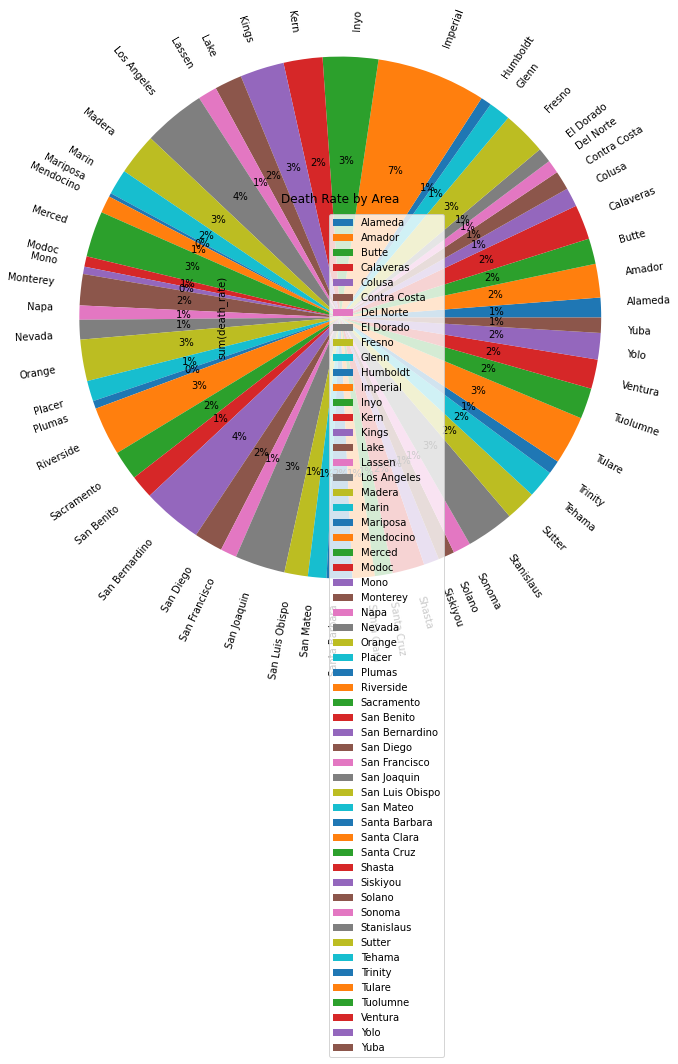

In [6]:
df1 = df1_new_death_rate_sum.set_index('area')
df1.plot(kind='pie', y='sum(death_rate)', autopct='%1.0f%%', radius=3, title='Death Rate by Area', figsize=(4,4), rotatelabels=True)

Covid-19 deaths recorded may differ among counties. From the Pie chart, we can see there are 58 counties with respective death rate. Most of counties have the death rate is between 0% - 3%.The Imperial County has the highest death rate which is 7%.   

**2. Statewide COVID-19 Cases Deaths Demographics**  
We have obtained this dataset from Califorina Open Data Portal through API as well. There are 9 columns in the original data, and we are interseted in the 'demographic_category', 'demographic_value ', and the 'deaths' columns. There are three demographic categories: age, gender, and race in this dataset. We have analyzed each demographic category and find the groups with the highest death number.  

In [7]:
demo_death = requests.get('https://data.ca.gov/api/3/action/datastore_search?resource_id=67c82c61-370a-4b4c-9067-15a68400b9ff&limit=50000')
demo_death_js = demo_death.json()
l2 = demo_death_js['result']['records']
demo_death_org = pd.json_normalize(l2)
demo_death_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10740 entries, 0 to 10739
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   percent_of_ca_population  10720 non-null  object
 1   percent_deaths            10740 non-null  object
 2   demographic_category      10740 non-null  object
 3   deaths                    10740 non-null  object
 4   total_cases               10740 non-null  object
 5   report_date               10740 non-null  object
 6   demographic_value         10740 non-null  object
 7   percent_cases             10740 non-null  object
 8   _id                       10740 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 755.3+ KB


In [8]:
# also read from .csv
demo_death = pd.read_csv('https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/e2c6a86b-d269-4ce1-b484-570353265183/download/covid19casesdemographics.csv')
demo_death.sample(5)

,demographic_category,demographic_value,total_cases,percent_cases,deaths,percent_deaths,percent_of_ca_population,report_date
2670,Age Group,Total,769831,100.0,14627,100.0,100.0,2020-09-17
10385,Race Ethnicity,White,133343,18.3,5490,30.3,36.6,2020-11-14
6750,Race Ethnicity,Black,1030,7.0,61,10.2,6.0,2020-04-13
10067,Race Ethnicity,Total,3155089,100.0,63289,100.0,100.0,2021-08-04
2620,Age Group,Total,485502,100.0,8751,100.0,100.0,2020-07-29


**Store the Dataset in SQL Database**   
The second  SQL table "demographic" corrsponds to the Statewide COVID-19 Cases Deaths Demographics dataset.

In [9]:
demo_death.to_sql('demographic', project_conn, if_exists='replace')

**Age Group**  
The age group 65+ appears the highest death number.  

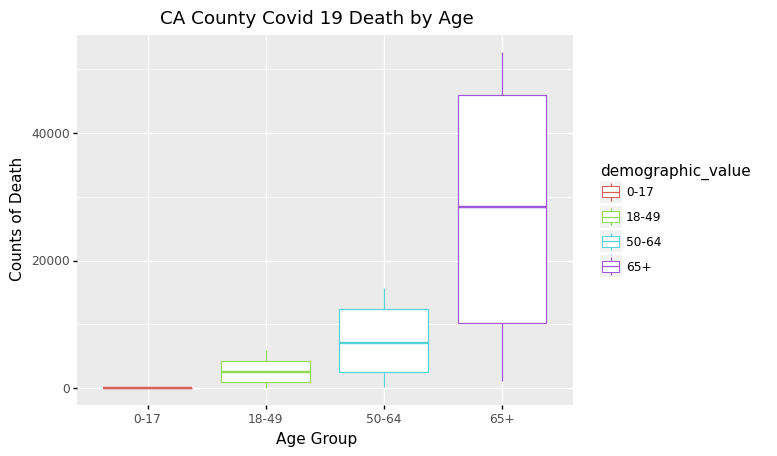

<ggplot: (8777463486323)>

In [10]:
demo_death_age = pd.read_sql_query("select * from demographic where demographic_category='Age Group'", project_conn)
demo_death_age.dropna()
demo_death_age_new = demo_death_age[(demo_death_age['demographic_value']!= "Missing")&(demo_death_age['demographic_value']!= "missing")&(demo_death_age['demographic_value']!= "Total")]
(p9.ggplot(data = demo_death_age_new,
           mapping=p9.aes(x='demographic_value', y='deaths', color='demographic_value'))
     + p9.geom_boxplot()
     + p9.xlab('Age Group')
     + p9.ylab('Counts of Death')
     + p9.ggtitle('CA County Covid 19 Death by Age')
)

**Gender**  
The male group appears higher death number than the female group.  

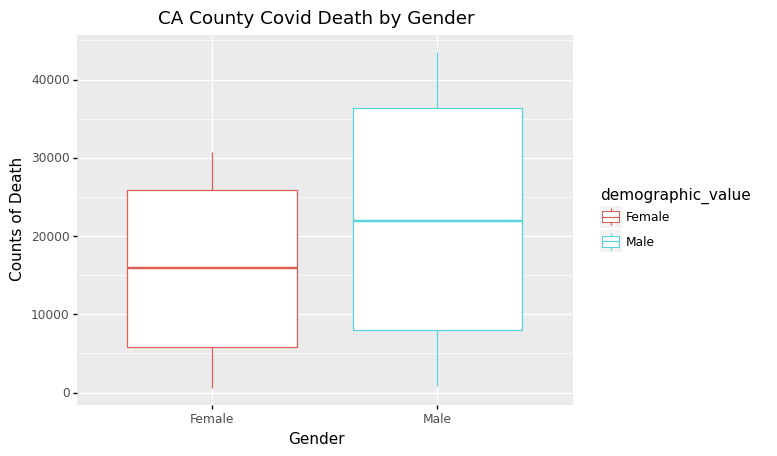

<ggplot: (8777463609754)>

In [11]:
demo_death_gender = pd.read_sql_query("select * from demographic where demographic_category='Gender'", project_conn)
demo_death_gender.dropna()
demo_death_gender_new = demo_death_gender[(demo_death_gender['demographic_value']!= "Unknown")&(demo_death_gender['demographic_value']!= "Total")]
(p9.ggplot(data = demo_death_gender_new,
           mapping=p9.aes(x='demographic_value', y='deaths', color='demographic_value'))
     + p9.geom_boxplot()
     + p9.xlab('Gender')
     + p9.ylab('Counts of Death')
     + p9.ggtitle('CA County Covid Death by Gender')
)

**Race**  
The Latino group appears the highest death number than other groups. Also, the White group also has a higher death number.

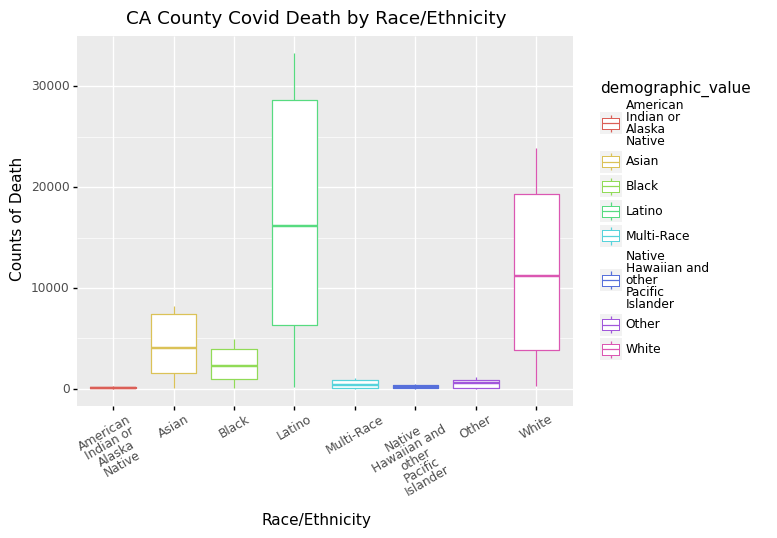

<ggplot: (8777398427302)>

In [12]:
demo_death_race = pd.read_sql_query("select * from demographic where demographic_category='Race Ethnicity'", project_conn)
demo_death_race.dropna()
demo_death_race_new = demo_death_race[demo_death_race['demographic_value'] != "Total"]
demo_death_race_new['demographic_value'] = ['\n'.join(wrap(x, 12)) for x in  demo_death_race_new['demographic_value']]
(p9.ggplot(data = demo_death_race_new,
           mapping=p9.aes(x='demographic_value', y='deaths', color='demographic_value'))
     + p9.geom_boxplot()
     + p9.xlab('Race/Ethnicity')
     + p9.ylab('Counts of Death')
     + p9.ggtitle('CA County Covid Death by Race/Ethnicity')
     + p9.theme(axis_text_x=p9.element_text(angle=30))
)

**3. COVID-19 Vaccine Progress Dashboard Data by ZIP Code**  

We have obtained this dataset from Califorina Open Data Portal through API. There are 14 columns in the original data. We are interseted in 3 of them: 'as_of_date', 'county', 'percent_of_population_fully_vaccinated'.  
1. 'as_of_date': the date used for cumulative vaccination rate  
2. 'county': residence of vaccination rate  
3. 'percent_of_population_fully_vaccinated': number of people vaccinated devided by population of each county  

In [13]:
vaccine_1 = requests.get('https://data.ca.gov/api/3/action/datastore_search?resource_id=15702a90-aa5d-49bc-8621-a8129630725a&limit=86436')
vaccine_2 = requests.get('https://data.ca.gov/api/3/action/datastore_search?offset=50000&limit=86436&resource_id=15702a90-aa5d-49bc-8621-a8129630725a')
vaccine_1_js = vaccine_1.json()
vaccine_2_js = vaccine_2.json()
l3 = vaccine_1_js['result']['records']
l4 = vaccine_2_js['result']['records']
vaccine_1_org = pd.json_normalize(l3)
vaccine_2_org = pd.json_normalize(l4)
vaccine = pd.concat([vaccine_1_org, vaccine_2_org])
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86436 entries, 0 to 36435
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   persons_partially_vaccinated                77884 non-null  object
 1   vaccine_equity_metric_quartile              82173 non-null  object
 2   percent_of_population_partially_vaccinated  77884 non-null  object
 3   persons_fully_vaccinated                    77884 non-null  object
 4   local_health_jurisdiction                   86191 non-null  object
 5   percent_of_population_with_1_plus_dose      77884 non-null  object
 6   age12_plus_population                       86436 non-null  object
 7   redacted                                    86436 non-null  object
 8   vem_source                                  86436 non-null  object
 9   county                                      86191 non-null  object
 10  as_of_date            

**Store the Dataset in SQL Database**  
The third SQL table "vaccine" corrsponds to the Statewide COVID-19 Vaccine Progress Dashboard Data by ZIP Code. 

In [14]:
vaccine.to_sql('vaccine', project_conn, if_exists='replace')
vaccine_sql = pd.read_sql_query('select county, percent_of_population_fully_vaccinated, as_of_date From vaccine', project_conn )
vaccine_sql['Week'] = pd.to_datetime(vaccine_sql['as_of_date'], format='%Y-%m-%d')
vaccine_sql = vaccine_sql.dropna()
vaccine_week = vaccine_sql.set_index('county')
vaccine_week['fully_vaccinated_rates'] = vaccine_week['percent_of_population_fully_vaccinated'].astype(float)
vaccine_week_new = vaccine_week.groupby([vaccine_week.index, 'Week']).sum()
maxcounty = vaccine_week_new.idxmax(axis = 0)
mincounty = vaccine_week_new.idxmin(axis = 0)
vaccine_week_new = vaccine_week_new.reset_index()
vaccine_week_new

,county,Week,fully_vaccinated_rates
0,Alameda,2021-01-05,0.007096
1,Alameda,2021-01-12,0.287772
2,Alameda,2021-01-19,0.458458
3,Alameda,2021-01-26,0.695578
4,Alameda,2021-02-02,1.039686
...,...,...,...
2802,Yuba,2021-11-09,4.879324
2803,Yuba,2021-11-16,4.902440
2804,Yuba,2021-11-23,4.923948
2805,Yuba,2021-11-30,4.949258


In [30]:
px.bar(vaccine_week_new, x="Week", y="fully_vaccinated_rates", title="CA County Fully Vaccinated Rates by Month",
       color="county", labels = {"fully_vaccinated_rates": "Fully Vaccinated Rates", "Week": "Month"}, width=800, height=400)

This chart shows each county's fully vaccinated rates in 2021. The overall trend of full vaccination rate has been increasing monthly in California. Los Angeles county has a relatively high vaccines rate, and Mendocino county has a relatively low vaccines rate. There are some discrepancies among the counties as some of the populations are different.  

**Joined Covid 19 Death and Vaccine Dataset**

In [16]:
# Get datasets from the privouus
dea = df1_new
vac = vaccine
# Format the dates
dea['date'] = pd.to_datetime(dea['date'], format='%Y-%m-%d')
vac['as_of_date'] = pd.to_datetime(vac['as_of_date'], format='%Y-%m-%d')
# Store them in SQL database
dea.to_sql('death2',project_conn,if_exists='replace')
vac.to_sql('vaccine2',project_conn,if_exists='replace')

In [17]:
df_combind = pd.read_sql_query("SELECT d.death_rate, d.area, d.date, v.as_of_date, v.local_health_jurisdiction, v.percent_of_population_fully_vaccinated FROM death2 d JOIN vaccine2 v ON d.area=v.local_health_jurisdiction AND d.date=v.as_of_date",project_conn)
df_combind = df_combind[['death_rate', 'area', 'date','percent_of_population_fully_vaccinated']]
df_combind['date'] = df_combind['date'].apply(lambda x: x[:10])
df_combind['date'] = pd.to_datetime(df_combind['date'], format='%Y-%m-%d')
df_combind['percent_of_population_fully_vaccinated'] = df_combind['percent_of_population_fully_vaccinated'].astype(float)
df_combind = df_combind.rename({"percent_of_population_fully_vaccinated":"vaccination rate"}, axis='columns')
df_combind.sample(5)

,death_rate,area,date,vaccination rate
44695,0.001114,Placer,2021-10-19,0.508257
66583,0.000730,San Mateo,2021-09-21,0.804484
11080,0.000179,Humboldt,2021-01-12,NaN
31182,0.002635,Los Angeles,2021-12-07,0.716707
34405,0.000588,Mendocino,2021-07-20,0.555465


In [18]:
df_combined_date_sum = df_combind.groupby('date').mean()
df_combined_date_sum.reset_index(inplace=True)
df_combined_date_sum.sample(5)

,date,death_rate,vaccination rate
25,2021-06-29,0.001392,0.542307
29,2021-07-27,0.001407,0.563488
38,2021-09-28,0.001598,0.614251
10,2021-03-16,0.001318,0.166908
33,2021-08-24,0.001467,0.583346


<AxesSubplot:title={'center':'Trends of Death Rate and Vacination Rate'}, xlabel='Month', ylabel='Death Rate'>

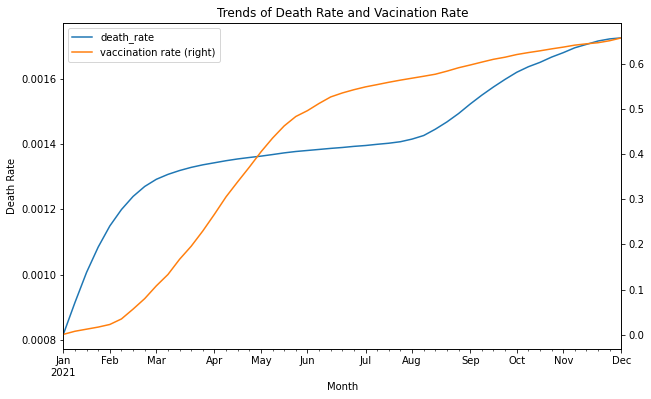

In [29]:
df_combined_date_sum.plot(x='date', secondary_y=['vaccination rate'], title = 'Trends of Death Rate and Vacination Rate',
                          figsize = (10,6), xlabel='Month', ylabel='Death Rate')

This is a time series plot with two y variables. The blue line represents the rate of death, and the orange line represents the rate of vaccination. We have observed that there is a strong negative correlation between death and vaccination. The rapid increases in vaccination from March 2021 to June 2021 has slowed down both the transmission of the disease and the death rates. Once vaccination has slowed down, the death rate rose again. It might have something to do with the new variations of Covid-19.  

**4. Local Area Unemployment Statistics (LAUS)**  

We obtained this dataset from State of California Employment Development Department (EDD) website. We have requested all California county unemployment data for 2020 and 2021. There are 12 columns in the original data.  
1. Area Type: The type of geographic area: California-Statewide, County, Metropolitan Area, Local Workforce Development Area, Sub-county places, Regional Planning Units.  
2. Area Name: The official name of the geographic area.  
3. Date: Numeric day, month, and year for the reported data.  
4. Year: The referenced 4-digit calendar year.  
5. Month: Calendar month.  
6. Seasonally Adjusted (Y/N): Seasonal changes have been removed or discounted. (Y/N).  
7. Status(Preliminary/Final): Current month data typically preliminary and is subject to revision, all others final and not subject to change.  
8. Labor Force: Civilian labor force.  
9. Employment: The proportion of the civilian noninstitutional population aged 16 years and over that is employed.  
10. Unemployment: Comprises all civilians 16 years and over who did not work during the survey week, who made specific efforts to find a job within the past four weeks, and who were available for work (except for temporary illness) during the survey week.
11. Unemployment Rate: The unemployment rate represents the number unemployed as a percent of the labor force.  12. Unemployment: Comprises all civilians 16 years and over who did not work during the survey week, who made specific efforts to find a job within the past four weeks, and who were available for work (except for temporary illness) during the survey week.

In [20]:
# Unemployment Dataset 
unemployment_2020 = requests.get('https://data.edd.ca.gov/resource/e6gw-gvii.json?area_type=County&year=2020')
unemployment_2021 = requests.get('https://data.edd.ca.gov/resource/e6gw-gvii.json?area_type=County&year=2021')
unemployment_2020_js = unemployment_2020.json()
unemployment_2021_js = unemployment_2021.json()
unemployment_2020_org = pd.json_normalize(unemployment_2020_js)
unemployment_2021_org = pd.json_normalize(unemployment_2021_js)
unemployment = pd.concat([unemployment_2020_org, unemployment_2021_org])
unemployment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1298 entries, 0 to 589
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   area_type                 1298 non-null   object
 1   area_name                 1298 non-null   object
 2   date                      1298 non-null   object
 3   year                      1298 non-null   object
 4   month                     1298 non-null   object
 5   seasonally_adjusted_y_n   1298 non-null   object
 6   status_preliminary_final  1298 non-null   object
 7   labor_force               1298 non-null   object
 8   employment                1298 non-null   object
 9   unemployment              1298 non-null   object
 10  unemployment_rate         1298 non-null   object
dtypes: object(11)
memory usage: 121.7+ KB


**Store the Dataset in SQL Database**  
The last SQL table "unemployment" corrsponds to the Local Area Unemployment Statistics (LAUS).  

In [21]:
unemployment.to_sql('unemployment', project_conn, if_exists='replace')
query = '''  
SELECT
area_name,
date,
year,
unemployment,
unemployment_rate
FROM unemployment
'''
unemp = pd.read_sql_query(query, connection)
unemp = pd.DataFrame(unemp)
unemp.head()

,area_name,date,year,unemployment,unemployment_rate
0,Alameda County,2020-01-01T00:00:00.000,2020,26200,0.031
1,Alpine County,2020-01-01T00:00:00.000,2020,30,0.046
2,Amador County,2020-01-01T00:00:00.000,2020,710,0.048
3,Butte County,2020-01-01T00:00:00.000,2020,5400,0.056
4,Calaveras County,2020-01-01T00:00:00.000,2020,950,0.044


In [22]:
def convert(col):
    col = col.replace("County", "")
    return col

In [23]:
unemp['area'] = unemp['area_name'].apply(convert)
unemp.area_name.str.strip().str.replace('County', '')
unemp['date']= pd.to_datetime(unemp['date'])
unemp['date'] = pd.to_datetime(unemp['date'], format='%Y%m%d')
unemp = unemp.astype({'unemployment': 'int32', 'unemployment_rate': 'float64'})
unemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298 entries, 0 to 1297
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   area_name          1298 non-null   object        
 1   date               1298 non-null   datetime64[ns]
 2   year               1298 non-null   object        
 3   unemployment       1298 non-null   int32         
 4   unemployment_rate  1298 non-null   float64       
 5   area               1298 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 55.9+ KB


In [27]:
px.bar(data_frame=unemp, x="date", y="unemployment", color="area", width=800, height=400)

The chart above shows that April 2020 was the turning point in terms of unemployment whereby the overall number of unemployed almost tripled, compared to earlier months in 2020. After summer 2020, unemployment number among the population has been decreasing steadily but over a year later, number of people unemployed in October 2021 is still noticeably higher than pre-Covid numbers. From the graph, Los Angeles county has the largest unemployed population. One thing to note however is that LA county has the greatest population, which may not reflect how counties are truly impacted by Covid-19.

In [31]:
subset = unemp.groupby(["area", "year"])["unemployment_rate"].mean()
subset = pd.DataFrame(subset)
subset.reset_index(inplace=True)
subset["unemployment_rate"] = subset["unemployment_rate"] * 100
subset.head()

,area,year,unemployment_rate
0,Alameda,2020,8.825000
1,Alameda,2021,6.200000
2,Alpine,2020,11.925000
3,Alpine,2021,8.190000
4,Amador,2020,9.166667


In [32]:
px.bar(subset, x="area", y="unemployment_rate", color="year", barmode = 'group', width=800, height=400)

This chart shows each county's unemployement rate averages in both 2020 and 2021. Unemployment rate is overall higher for most counties in 2020 as counties slowly recover in 2021. Los Angeles County, despite having the largest unemployed population, still has a relatively high unemployement rate in 2020, while Imperial, Colusa, and Tulare counties have higher unemployment rates. There are some discreptancies among the counties as some of them hover around 5% while the rest hover around 10%.

### IV. Statistical Findings  

1. The average deaths for the elder(65+) group in each county, which is about 20,000 higher than the next highest group. The average deaths of males in each county is about 10,000 higher than females. Latino group has the highest death rate, which is about 45%.  
2. The increasing of death slowed down over time because of the invention of vaccination.  
3. Most counties in CA experienced similar impacts of covid, except Imperial, which suffered a much more significant impact.  
4. When the covid 19 started spreading, the unemployment rate increased dramatically.  
5. We suspect that there are underlying social issues because Latino and Whits have the highest death rate, but we cannot be sure about the specific reasons from the limited data we have.   

### V. Conclusion    
Our conclusions are that among all ages groups, the elders (65+) suffer the greatest number of deaths. Deaths from covid is higher for the male population than the female counterparts. Among all racial groups, Latinos lead with the highest overall death percentage from covid, closely followed by the white population. Since most ethniticy groups are well below the aforementioned groups in terms of death percentage, it is unclear if there is a social disadvantage. Imperial county was the most affected county of all of California, with the unemployment rate and death rate being the highest.  